# 6장. 두 개의 층을 연결합니다.

### <직접 해보세요!> SingleLayer 클래스를 벡터 연산으로 바꾸기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, 
                                                  test_size=0.2, random_state=42)

In [4]:
print(X_train.shape, X_val.shape)

(364, 30) (91, 30)


In [5]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None              # 가중치
        self.b = None              # 절편
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.w_history = []        # 가중치 기록
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터
        self.m = 0                 # 샘플 개수

    def forpass(self, X):
        z = np.dot(X, self.w) + self.b        # 선형 식을 계산합니다.
        return z

    def backprop(self, X, err):
        w_grad = np.dot(err, X) / self.m      # 가중치에 대한 그래디언트를 계산합니다.
        b_grad = np.sum(err) / self.m         # 절편에 대한 그래디언트를 계산합니다.
        return w_grad, b_grad

    def activation(self, z):
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
        
    def fit(self, X, y, epochs=100, X_val=None, y_val=None):
        self.m = X.shape[0]                   # 샘플 개수를 저장합니다.
        self.w = np.ones(X.shape[1])          # 가중치를 초기화합니다.
        self.b = 0                            # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            z = self.forpass(X)               # 정방향 계산을 수행합니다.
            a = self.activation(z)            # 활성화 함수를 적용합니다.
            err = y - a                       # 오차를 계산합니다.
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w_grad, b_grad = self.backprop(X, err)
            # 그래디언트에서 페널티 항의 미분 값을 뺍니다.
            w_grad -= self.l1 * np.sign(self.w) + self.l2 * self.w
            # 가중치와 절편을 업데이트합니다.
            self.w += self.lr * w_grad
            self.b += self.lr * b_grad
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
            # 평균 손실과 규제 손실을 더하여 리스트에 추가합니다.
            self.losses.append(loss/self.m + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(X_val, y_val)
    
    def predict(self, X):
        z = self.forpass(X)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, X, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(X) == y)
    
    def reg_loss(self):
        # 가중치에 규제를 적용합니다.
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, X_val, y_val):
        z = self.forpass(X_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a)+(1-y_val)*np.log(1-a)))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [8]:
layer = SingleLayer(l2=0.001)
layer.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val, epochs=20000)
layer.score(X_val_scaled, y_val)

0.978021978021978

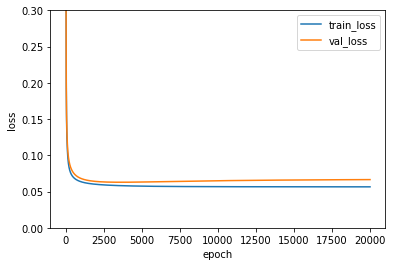

In [9]:
plt.ylim(0, 0.3)
plt.plot(layer.losses)
plt.plot(layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

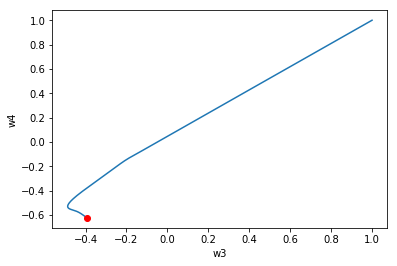

In [10]:
w3 = []
w4 = []
for w in layer.w_history:
    w3.append(w[2])
    w4.append(w[3])
plt.plot(w3, w4)
plt.plot(w3[-1], w4[-1], 'ro')
plt.xlabel('w3')
plt.ylabel('w4')
plt.show()

### <직접 해보세요!> DualLayer 클래스 만들기

In [11]:
class DualLayer:
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터
        self.m = 0                 # 샘플 개수

    def forpass(self, X):
        z1 = np.dot(X, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.activation(z1)            # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, X, err):
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / self.m
        b2_grad = np.sum(err) / self.m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(X.T, err_to_hidden) / self.m
        b1_grad = np.sum(err_to_hidden, axis=0) / self.m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def activation(self, z):
        a = 1 / (1 + np.exp(-z))      # 시그모이드 계산
        return a
        
    def fit(self, X, y, epochs=100, X_val=None, y_val=None):
        self.m = X.shape[0]           # 샘플 개수를 저장합니다.
        y = y.reshape(-1, 1)          # 타깃을 열 벡터로 바꿉니다.
        # 은닉층과 출력층의 가중치를 초기화합니다.
        self.w1 = np.ones((X.shape[1], self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)               # 은닉층의 크기
        self.w2 = np.ones((self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0
        # epochs만큼 반복합니다.
        for i in range(epochs):
            z = self.forpass(X)       # 정방향 계산을 수행합니다.
            a = self.activation(z)    # 활성화 함수를 적용합니다.
            err = y - a               # 오차를 계산합니다.
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(X, err)
            # 그래디언트에서 페널티 항의 미분 값을 뺍니다
            w1_grad -= self.l1 * np.sign(self.w1) + self.l2 * self.w1
            w2_grad -= self.l1 * np.sign(self.w2) + self.l2 * self.w2
            # 은닉층의 가중치와 절편을 업데이트합니다.
            self.w1 += self.lr * w1_grad
            self.b1 += self.lr * b1_grad
            # 출력층의 가중치와 절편을 업데이트합니다.
            self.w2 += self.lr * w2_grad
            self.b2 += self.lr * b2_grad
            # 안전한 로그 계산을 위해 클리핑한 후 손실을 계산합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
            # 평균 손실과 규제 손실을 더하여 리스트에 추가합니다.
            self.losses.append(loss/self.m + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(X_val, y_val)
    
    def predict(self, X):
        z = self.forpass(X)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, X, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(X) == y.reshape(-1, 1))
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
    
    def update_val_loss(self, X_val, y_val):
        y_val = y_val.reshape(-1, 1)       # 타깃을 열 벡터로 바꿉니다.
        z = self.forpass(X_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a)+(1-y_val)*np.log(1-a)))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

### <직접 해보세요!> 여러 개의 뉴런으로 훈련하기

In [12]:
dual_layer = DualLayer(l2=0.001)
dual_layer.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(X_val_scaled, y_val)

0.978021978021978

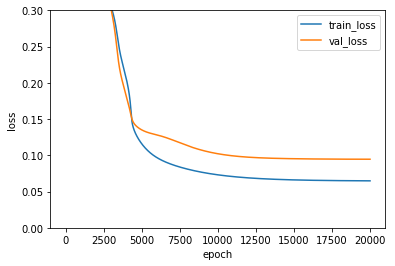

In [13]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [14]:
class DualLayer:
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터
        self.m = 0                 # 샘플 개수

    def forpass(self, X):
        z1 = np.dot(X, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.activation(z1)            # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, X, err):
        w2_grad = np.dot(self.a1.T, err) / self.m   # 가중치에 대한 그래디언트를 계산합니다
        b2_grad = np.sum(err) / self.m
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        w1_grad = np.dot(X.T, err_to_hidden) / self.m
        b1_grad = np.sum(err_to_hidden, axis=0) / self.m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def activation(self, z):
        a = 1 / (1 + np.exp(-z))      # 시그모이드 계산
        return a
        
    def fit(self, X, y, epochs=100, X_val=None, y_val=None):
        self.m = X.shape[0]           # 샘플 개수를 저장합니다.
        y = y.reshape(-1, 1)          # 타깃을 열 벡터로 바꿉니다.
        # 은닉층과 출력층의 가중치를 초기화합니다.
        self.w1 = np.random.normal(0, 1, (X.shape[1], self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                              # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, (self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0
        # epochs만큼 반복합니다.
        for i in range(epochs):
            z = self.forpass(X)       # 정방향 계산을 수행합니다.
            a = self.activation(z)    # 활성화 함수를 적용합니다.
            err = y - a               # 오차를 계산합니다.
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(X, err)
            # 그래디언트에서 페널티 항의 미분 값을 뺍니다
            w1_grad -= self.l1 * np.sign(self.w1) + self.l2 * self.w1
            w2_grad -= self.l1 * np.sign(self.w2) + self.l2 * self.w2
            # 은닉층의 가중치와 절편을 업데이트합니다.
            self.w1 += self.lr * w1_grad
            self.b1 += self.lr * b1_grad
            # 출력층의 가중치와 절편을 업데이트합니다.
            self.w2 += self.lr * w2_grad
            self.b2 += self.lr * b2_grad
            # 안전한 로그 계산을 위해 클리핑한 후 손실을 계산합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a)+(1-y)*np.log(1-a)))
            # 평균 손실과 규제 손실을 더하여 리스트에 추가합니다.
            self.losses.append(loss/self.m + self.reg_loss())
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(X_val, y_val)
    
    def predict(self, X):
        z = self.forpass(X)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, X, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(X) == y.reshape(-1, 1))
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
    
    def update_val_loss(self, X_val, y_val):
        y_val = y_val.reshape(-1, 1)       # 타깃을 열 벡터로 바꿉니다.
        z = self.forpass(X_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a)+(1-y_val)*np.log(1-a)))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

In [15]:
dual_layer = DualLayer(l2=0.001)
dual_layer.fit(X_train_scaled, y_train, X_val=X_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(X_val_scaled, y_val)

0.978021978021978

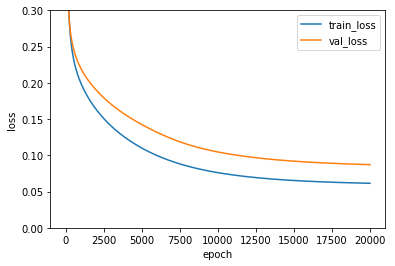

In [16]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [17]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic')
mlp.fit(X_train_scaled, y_train)
mlp.score(X_val_scaled, y_val)

/Users/rickypark/anaconda3/envs/do-it-dl/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.989010989010989

In [18]:
mlp.coefs_

[array([[ 0.41581076, -0.25017914,  0.34866819, -0.12447841, -0.40326429,
         -0.08994259,  0.36932648,  0.40270858,  0.19421428, -0.05529175],
        [ 0.2569648 , -0.46204447,  0.4460381 , -0.47231406, -0.36027048,
         -0.12510008,  0.60195848,  0.36040574,  0.3653781 , -0.27475896],
        [ 0.1615764 , -0.29148026,  0.31016702, -0.12185037, -0.09158762,
         -0.13882827,  0.17930822,  0.2502286 ,  0.07246078, -0.20733629],
        [ 0.224513  , -0.04155235,  0.16573727, -0.40615391, -0.38320845,
         -0.15350777,  0.41759498,  0.07516022,  0.08454283, -0.13846373],
        [ 0.08896069, -0.05576135,  0.27754805, -0.36569682, -0.3296534 ,
         -0.04089604,  0.28084946,  0.17448594,  0.36741585, -0.03994265],
        [ 0.4389019 , -0.02673162,  0.08203143, -0.33118222,  0.01499701,
         -0.19648636,  0.19383808,  0.3435765 , -0.00593083, -0.18275713],
        [ 0.02922476, -0.19552605, -0.01035101, -0.36230531, -0.34639169,
         -0.18289726,  0.4358350